In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import librosa
import numpy as np
import pickle
import bz2
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
pd.set_option('display.precision', 10)

## **Test Coordinates**

In [3]:
def get_cords():
    # Define the field dimensions in centimeters
    field_width = 280  # in cm
    field_height = 400  # in cm

    # Define the point spacing in centimeters
    point_spacing = 20  # in cm

    # Define the table's properties
    table_z = 75  # height of the table in cm
    table_x_min = 70  # x coordinate of the left edge of the table
    table_x_max = 210  # x coordinate of the right edge of the table
    table_y_min = 330  # y coordinate of the top edge of the table
    table_y_max = 400  # y coordinate of the bottom edge of the table

    # Calculate the number of points along each axis
    num_points_x = field_width // point_spacing + 1
    num_points_y = field_height // point_spacing + 1

    # Generate the points
    points = []
    index = 0

    for y in range(int(num_points_y)):
        for x in range(int(num_points_x)):
            point_x = x * point_spacing
            point_y = y * point_spacing

            # Check if the point is within the table's footprint
            if table_x_min <= point_x <= table_x_max and table_y_min <= point_y <= table_y_max:
                point_z = table_z  # Points on the table have z-coordinate 75
            else:
                point_z = 0  # Points on the ground have z-coordinate 0

            points.append({str(index): (point_x, point_y, point_z)})
            index += 1
    return points

In [4]:
def get_test_coors(test_coors_x, test_coors_y):
    test_coors_z = []
    for x, y in zip(test_coors_x, test_coors_y):
        if y >= 330 and x >= 70 and x <= 210:
            test_coors_z.append(75)
        else:
            test_coors_z.append(0)
    test_coors = [(x, y, z) for x, y, z in zip(test_coors_x, test_coors_y, test_coors_z)]
    return test_coors

In [5]:
# determine test
test_coors_x = [0, 200, 100, 280, 40, 160, 80, 220, 20, 160, 120, 260, 60, 240, 180, 100, 280, 40, 260, 80, 220, 0, 140, 180, 20]
test_coors_y = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 340, 360, 380, 400]
# test_coors_x = [0, 200, 100, 280, 160, 80, 20, 160, 120, 260, 60, 240, 100, 280, 40, 80, 220, 0, 180, 20]
# test_coors_y = [0, 20, 40, 60, 100, 120, 160, 180, 200, 220, 240, 260, 300, 320, 340, 380, 400, 340, 380, 400]
test_coors = get_test_coors(test_coors_x, test_coors_y)
# determine train
tot_coords = get_cords()
coordinates = [list(cor.values())[0] for cor in tot_coords]
train_coors = [cor for cor in coordinates if cor not in test_coors]

In [6]:
print('Number of Train coords:', len(train_coors))
print('Number of Test coords:', len(test_coors))

Number of Train coords: 290
Number of Test coords: 25


## **Load TDOA df**

In [7]:
# Load dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/actual_tdoa.pkl', 'rb') as file:
    actual_df = pickle.load(file)
    print('Loaded Intra TDOAs dataframe.')
    print('Type:', type(actual_df), '\nShape:', actual_df.shape, '\nOverview:', actual_df)

Loaded Intra TDOAs dataframe.
Type: <class 'pandas.core.frame.DataFrame'> 
Shape: (315, 19) 
Overview:         tdoa01_k1     tdoa02_k1     tdoa03_k1     tdoa12_k1     tdoa13_k1  \
0    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
1    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
2    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
3    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
4    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
..            ...           ...           ...           ...           ...   
310 -0.0000583248 -0.0000766069 -0.0000944988 -0.0000182821 -0.0000361740   
311 -0.0000801971 -0.0001043277 -0.0001276180 -0.0000241306 -0.0000474209   
312 -0.0001005128 -0.0001300160 -0.0001582434 -0.0000295032 -0.0000577306   
313 -0.0001201554 -0.0001548378 -0.0001878190 -0.0000346824 -0.0000676636   
314 -0.0001390317 -0.0001786777 -0.0002162099 -0.0

In [8]:
print(actual_df.columns)
print(actual_df.shape)

Index(['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1',
       'tdoa23_k1', 'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2',
       'tdoa13_k2', 'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3',
       'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3', 'label'],
      dtype='object')
(315, 19)


## **Data Handle**

### **Spectrums**

In [ ]:
# load spectrums from files
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
# with open(path + '/power_spectrums_k1.pkl', 'rb') as file:
#     power_spectrums_k1 = pickle.load(file)
with open(path + '/power_spectrums_k2.pkl', 'rb') as file:
    power_spectrums_k2 = pickle.load(file)
with open(path + '/power_spectrums_k3.pkl', 'rb') as file:
    power_spectrums_k3 = pickle.load(file)
with open(path + '/labels.pkl', 'rb') as file:
    coors = pickle.load(file)

# print(power_spectrums_k1.shape, np.array(labels_k1).shape)
print(power_spectrums_k2.shape, power_spectrums_k3.shape)
print(coors)

(315, 4, 401, 722) (315, 4, 401, 722)
[(0, 0, 0), (20, 0, 0), (40, 0, 0), (60, 0, 0), (80, 0, 0), (100, 0, 0), (120, 0, 0), (140, 0, 0), (160, 0, 0), (180, 0, 0), (200, 0, 0), (220, 0, 0), (240, 0, 0), (260, 0, 0), (280, 0, 0), (0, 20, 0), (20, 20, 0), (40, 20, 0), (60, 20, 0), (80, 20, 0), (100, 20, 0), (120, 20, 0), (140, 20, 0), (160, 20, 0), (180, 20, 0), (200, 20, 0), (220, 20, 0), (240, 20, 0), (260, 20, 0), (280, 20, 0), (0, 40, 0), (20, 40, 0), (40, 40, 0), (60, 40, 0), (80, 40, 0), (100, 40, 0), (120, 40, 0), (140, 40, 0), (160, 40, 0), (180, 40, 0), (200, 40, 0), (220, 40, 0), (240, 40, 0), (260, 40, 0), (280, 40, 0), (0, 60, 0), (20, 60, 0), (40, 60, 0), (60, 60, 0), (80, 60, 0), (100, 60, 0), (120, 60, 0), (140, 60, 0), (160, 60, 0), (180, 60, 0), (200, 60, 0), (220, 60, 0), (240, 60, 0), (260, 60, 0), (280, 60, 0), (0, 80, 0), (20, 80, 0), (40, 80, 0), (60, 80, 0), (80, 80, 0), (100, 80, 0), (120, 80, 0), (140, 80, 0), (160, 80, 0), (180, 80, 0), (200, 80, 0), (220, 80, 0)

In [ ]:
def stack_data(data):
    finals = []
    for i in range(315):
        k1_data = data[0][i]
        k2_data = data[1][i]
        k3_data = data[2][i]
        stacked = np.stack((k1_data, k2_data, k3_data), axis=0)
        finals.append(stacked)
    return np.array(finals)

In [ ]:
# store the spectrums of each channel at a dict
channels_spectrums_dict = {
    'ch0': [],
    'ch1': [],
    'ch2': [],
    'ch3': [],
}

# store channels data
# ch0
channels_spectrums_dict['ch0'].append(np.array([data[0] for data in power_spectrums_k1]))
channels_spectrums_dict['ch0'].append(np.array([data[0] for data in power_spectrums_k2]))
channels_spectrums_dict['ch0'].append(np.array([data[0] for data in power_spectrums_k3]))
channels_spectrums_dict['ch0'] = np.array(channels_spectrums_dict['ch0'])
# ch1
channels_spectrums_dict['ch1'].append(np.array([data[1] for data in power_spectrums_k1]))
channels_spectrums_dict['ch1'].append(np.array([data[1] for data in power_spectrums_k2]))
channels_spectrums_dict['ch1'].append(np.array([data[1] for data in power_spectrums_k3]))
channels_spectrums_dict['ch1'] = np.array(channels_spectrums_dict['ch1'])
# ch2
channels_spectrums_dict['ch2'].append(np.array([data[2] for data in power_spectrums_k1]))
channels_spectrums_dict['ch2'].append(np.array([data[2] for data in power_spectrums_k2]))
channels_spectrums_dict['ch2'].append(np.array([data[2] for data in power_spectrums_k3]))
channels_spectrums_dict['ch2'] = np.array(channels_spectrums_dict['ch2'])
# ch3
channels_spectrums_dict['ch3'].append(np.array([data[3] for data in power_spectrums_k1]))
channels_spectrums_dict['ch3'].append(np.array([data[3] for data in power_spectrums_k2]))
channels_spectrums_dict['ch3'].append(np.array([data[3] for data in power_spectrums_k3]))
channels_spectrums_dict['ch3'] = np.array(channels_spectrums_dict['ch3'])

print(channels_spectrums_dict['ch0'].shape)
print(channels_spectrums_dict['ch1'].shape)
print(channels_spectrums_dict['ch2'].shape)
print(channels_spectrums_dict['ch3'].shape)

#### **Gather Labels**

At first, let's gather all the pairs of the tdoas and spectrums and see how the model does.

In [ ]:
# ch0_k1, ch0_k2, ch0_k3 = channels_dict['ch0'][0][i], channels_dict['ch0'][1][i], channels_dict['ch0'][2][i]
        # ch1_k1, ch1_k2, ch1_k3 = channels_dict['ch1'][0][i], channels_dict['ch1'][1][i], channels_dict['ch1'][2][i]
        # ch2_k1, ch2_k2, ch2_k3 = channels_dict['ch2'][0][i], channels_dict['ch2'][1][i], channels_dict['ch2'][2][i]
        # ch3_k1, ch3_k2, ch3_k3 = channels_dict['ch3'][0][i], channels_dict['ch3'][1][i], channels_dict['ch3'][2][i]
        # l1 = [ch0_k1, ch0_k1, ch0_k1, ch1_k1, ch1_k1, ch2_k1] + [ch0_k2, ch0_k2, ch0_k2, ch1_k2, ch1_k2, ch2_k2] + [ch0_k3, ch0_k3, ch0_k3, ch1_k3, ch1_k3, ch2_k3]
        # l2 = [ch1_k1, ch2_k1, ch3_k1, ch2_k1, ch3_k1, ch3_k1] + [ch1_k2, ch2_k2, ch3_k2, ch2_k2, ch3_k2, ch3_k2] + [ch1_k3, ch2_k3, ch3_k3, ch2_k3, ch3_k3, ch3_k3]
        # for j in range(len(l1)):
        #     df['data'].append(np.stack((l1[j], l2[j]), axis=0))
        #     df['tdoa'].append(act_df.loc[i, tdoa_names[j]])

In [ ]:
tdoa_names = ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1',
       'tdoa23_k1', 'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2',
       'tdoa13_k2', 'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3',
       'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']

def assign_labels_and_data(path, act_df, labels, tdoa_names, num_of_kinects=3):
    df = {
        'data': [],
        'tdoa': []
    }
    for j in range(1, num_of_kinects-1):
        with open(path + f'/power_spectrums_k{j+1}.pkl', 'rb') as file:
            power_spectrums = pickle.load(file)
            print(f"---> Loaded k{j+1} Spectrums.")
            for i in range(len(labels)):
                l1 = [power_spectrums[i][0], power_spectrums[i][0], power_spectrums[i][0], power_spectrums[i][1], power_spectrums[i][2], power_spectrums[i][2]]
                l2 = [power_spectrums[i][1], power_spectrums[i][2], power_spectrums[i][3], power_spectrums[i][2], power_spectrums[i][3], power_spectrums[i][3]]
                for z in range(6):
                    df['data'].append(np.stack((l1[z], l2[z]), axis=0))
                    df['tdoa'].append(act_df.loc[i, tdoa_names[z + j*6]])
                print(i, end=', ')
            del power_spectrums
            print('\n')
    df = pd.DataFrame(df)
    return df

In [ ]:
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
power_spec_df = assign_labels_and_data(path, actual_df, actual_df['label'].to_list(), tdoa_names=tdoa_names)
print(power_spec_df.shape)

In [ ]:
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
# Pickle and compress the data
with bz2.BZ2File(path + '/tdoa_df_power_spectrum.pkl.bz2', 'wb') as f:
    pickle.dump(power_spec_df, f)

# save cross correlograms labels
# with open(path + '/tdoa_df_power_spectrum_k23.pkl', 'wb') as file:
#     pickle.dump(power_spec_df, file)

print("Correlograms with TDOAs saved to file successfully.")

In [ ]:
# To decompress and load
# with bz2.BZ2File('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums/tdoa_df_power_spectrum.pkl.bz2', 'rb') as f:
#     power_spec_df = pickle.load(f)

with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums/tdoa_df_power_spectrum.pkl', 'rb') as file:
    power_spec_df = pickle.load(file)
    print('Loaded Intra TDOAs dataframe.')

In [ ]:
print(power_spec_df.shape)

### **Raw Samples**

In [ ]:
# load spectrums from files
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_samples_dict.pkl', 'rb') as file:
    denoised_samples_dict = pickle.load(file)

(4, 145000)


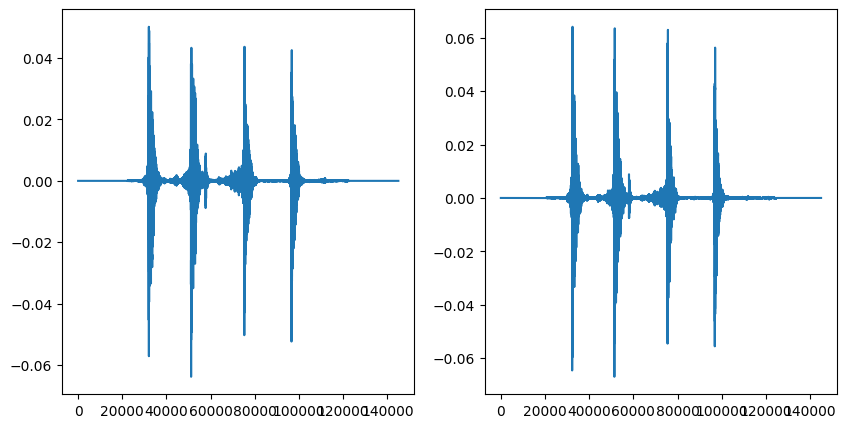

In [ ]:
test_samples = denoised_samples_dict[(140, 320, 0)]
print(test_samples[0].shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(test_samples[1][0])
axes[1].plot(test_samples[2][0])
plt.show()

In [ ]:
tdoa_names = ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1',
       'tdoa23_k1', 'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2',
       'tdoa13_k2', 'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3',
       'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']

def assign_labels_and_data_raw_data(samples_dict, act_df, labels, tdoa_names, num_of_kinects=3):
    df = {
        'data': [],
        'tdoa': []
    }
    for i in range(len(labels)):
        lbl = labels[i]
        print(i, end=', ')
        for j in range(num_of_kinects):
                ch0, ch1, ch2, ch3 = samples_dict[lbl][j]
                l1 = [ch0, ch0, ch0, ch1, ch1, ch2]
                l2 = [ch1, ch2, ch3, ch2, ch3, ch3]
                for z in range(6):
                    df['data'].append(np.stack((l1[z], l2[z]), axis=0))
                    df['tdoa'].append(act_df.loc[i, tdoa_names[z + j*6]])
                del l1, l2
    df = pd.DataFrame(df)
    return df

In [ ]:
raw_data_df = assign_labels_and_data_raw_data(denoised_samples_dict, actual_df, actual_df['label'].to_list(), tdoa_names=tdoa_names)
print(raw_data_df.shape)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [ ]:
print(raw_data_df.loc[0, 'data'].shape)

(2, 145000)


### **Hanlde measured TDOA data**

In [ ]:
# Load dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_tdoa_df_int20.pkl', 'rb') as file:
    tdoa_df = pickle.load(file)
    print('Loaded Intra TDOAs dataframe.')
    print('Type:', type(tdoa_df), '\nShape:', tdoa_df.shape, '\nOverview:', tdoa_df)

Loaded Intra TDOAs dataframe.
Type: <class 'pandas.core.frame.DataFrame'> 
Shape: (315, 19) 
Overview:        tdoa01_k1    tdoa02_k1    tdoa03_k1    tdoa12_k1    tdoa13_k1  \
0    0.000481250  0.000537500  0.000656250  0.000056250  0.000209375   
1    0.000471875  0.000500000  0.000646875  0.000046875  0.000181250   
2    0.000481250  0.000459375  0.000653125  0.000062500  0.000150000   
3    0.000431250  0.000590625  0.000656250  0.000059375  0.000206250   
4    0.000421875  0.000571875  0.000656250  0.000068750  0.000212500   
..           ...          ...          ...          ...          ...   
310 -0.000018750 -0.000018750 -0.000028125 -0.000006250 -0.000012500   
311 -0.000046875 -0.000021875 -0.000031250 -0.000012500 -0.000025000   
312 -0.000015625 -0.000015625 -0.000018750 -0.000012500 -0.000018750   
313 -0.000062500 -0.000053125 -0.000071875 -0.000015625 -0.000028125   
314 -0.000059375 -0.000056250 -0.000071875 -0.000015625 -0.000034375   

       tdoa23_k1    tdoa01_k2   

## **Handle Network Data**

Okay, so there's a new idea that just popped in my head which is a two branched network. The first branch gets the power spectrums of each 4 channels and the second branch gets the measured TDOAs. I'll train one model for each of the kinects and we'll see how well will they perform. Hopefully something good will happen.

In the following section, the needed data for the network will be processed.

In [ ]:
k2_measured_tdoas = tdoa_df[['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2','tdoa13_k2', 'tdoa23_k2']].to_numpy()
k2_actual_tdoas = actual_df[['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2','tdoa13_k2', 'tdoa23_k2']].to_numpy()
k3_measured_tdoas = tdoa_df[['tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']].to_numpy()
k3_actual_tdoas = actual_df[['tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']].to_numpy()

In [ ]:
print(k2_measured_tdoas.shape)

(315, 6)


## **CNN model**

In [ ]:
def get_tdoa_cnn_model(input_shape_conv, input_shape_mlp):
    # Branch 1: Conv2D Layers
    input_branch1 = Input(shape=(input_shape_conv))
    x1 = Conv2D(128, (7, 7), activation='relu')(input_branch1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(3, 3))(x1)
    # second layer
    x1 = Conv2D(64, (5, 5), activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(3, 3))(x1)
    # third layer
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(3, 3))(x1)
    # Flatten for concatenation later
    x1 = Flatten()(x1)

    # Branch 2: MLP Layers
    input_branch2 = Input(shape=(input_shape_mlp))
    x2 = Dense(128, activation='relu')(input_branch2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    x2 = Dense(64, activation='relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    # Concatenate the outputs from both branches
    concatenated = concatenate([x1, x2])

    # Final Dense layers
    x = Dense(256, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation='linear')(x)

    # Create the model
    model = Model(inputs=[input_branch1, input_branch2], outputs=x)
    # Compile the model
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    return model

In [ ]:
inp_shape_CNN = (401, 722, 4)
inp_shape_MLP = (k2_measured_tdoas.shape[1],)
tdoa_model = get_tdoa_cnn_model(inp_shape_CNN, inp_shape_MLP)
tdoa_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 401, 722, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 395, 716, 128)  │         25,216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 395, 716, 128)  │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 131, 238, 128)  │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 127, 234, 64)   │        204,864 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 127, 234, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 42, 78, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 40, 76, 32)     │         18,464 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 40, 76, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 13, 25, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,973,094 (11.34 MB)

 Trainable params: 2,971,750 (11.34 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
X_CNN = np.transpose(power_spectrums_k2, (0, 2, 3, 1))
X_MLP = k2_measured_tdoas
y = k2_actual_tdoas
# standart scale tdoa input
xscaler = StandardScaler()
X_MLP = xscaler.fit_transform(X_MLP)
# standard sclae tdoa target
yscaler = StandardScaler()
y = yscaler.fit_transform(y)

# get test index and split train and test
test_indexes = [coordinates.index(cor) for cor in test_coors]
train_indexes = [coordinates.index(cor) for cor in train_coors]
X_train_MLP = np.array([X_MLP[i] for i in train_indexes])
X_train_CNN = np.array([X_CNN[i] for i in train_indexes])
y_train = np.array([y[i] for i in train_indexes])
X_test_MLP = np.array([X_MLP[i] for i in test_indexes])
X_test_CNN = np.array([X_CNN[i] for i in test_indexes])
y_test = np.array([y[i] for i in test_indexes])

print(X_train_MLP.shape, X_train_CNN.shape, y_train.shape)
print(X_test_MLP.shape, X_test_CNN.shape, y_test.shape)

(290, 6) (290, 401, 722, 4) (290, 6)
(25, 6) (25, 401, 722, 4) (25, 6)


In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=25,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

hist = tdoa_model.fit([X_train_CNN, X_train_MLP], y_train, epochs=150, batch_size=32, validation_split=0.05, verbose=1, callbacks=[es, reduce_lr])

Epoch 1/150


In [ ]:
tdoa_model.save('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/models/CNN-TDOA/tdoa_model.keras')

In [ ]:
pred = tdoa_model.predict([X_test_CNN, X_test_MLP])

1/1 [==============================] - 2s 2s/step


In [ ]:
pred = yscaler.inverse_transform(pred)
print(pred)

[[ 9.7754244e-03 -5.1193028e-03 -1.3268832e-03 -2.1926120e-04
  -5.0002756e-03 -1.7900621e-03]
 [ 8.0732489e-03  3.1790306e-04  1.5402845e-02  1.1574958e-03
  -3.8122758e-03 -2.0651554e-03]
 [ 7.8231059e-03  3.8547528e-03  2.2820355e-02  2.4924399e-03
  -5.0648781e-03 -2.8554057e-03]
 [ 4.1658990e-03  2.7353135e-03  1.7119713e-02  1.6341025e-03
  -2.8190671e-03 -1.9100209e-03]
 [ 6.0377102e-03  2.6315928e-03  1.7081352e-02  1.8828429e-03
  -4.9894648e-03 -2.7698239e-03]
 [ 1.0098882e-02  9.3044352e-04  1.8553251e-02  1.5157489e-03
  -4.1566496e-03 -2.3266571e-03]
 [ 8.4090987e-03 -2.9650580e-03  1.6197955e-02  1.3954928e-03
  -7.0172898e-03 -3.2425656e-03]
 [ 1.0461137e-02 -1.1640734e-03  1.5244437e-02  1.3279043e-03
  -4.4254544e-03 -2.0452188e-03]
 [ 8.9996839e-03  1.1063025e-03  1.8334500e-02  1.7034869e-03
  -5.5093179e-03 -2.8096309e-03]
 [ 8.4762014e-03  2.5198713e-03  1.4975344e-02  1.5394479e-03
  -4.4746012e-03 -2.3052085e-03]
 [ 8.2593383e-03  3.3048352e-03  1.2856727e-02  1.

In [ ]:
print(np.mean((pred - yscaler.inverse_transform(y_test) ** 2)))

0.0023721784476889067
